## 1. Reading the data

### Package imports

In [316]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [317]:
from random import sample
import numpy as np
def add_noise(data, cx, sigma):
    nnp = int(cx*len(data))
    idx = sample(range(len(data)), nnp)
    noise = np.random.normal(0, sigma, nnp)
    for i in range(nnp):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(len(data)):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data


In [318]:
import torch
import eval
import numpy as np
from torch import Tensor
from torch.autograd import Variable
def train(data, target, model, criterion, optimizer, epochs):
    model.train()
    clean_data = Variable(Tensor(data))
    target = Variable(Tensor(target))
    err = []
    for e in range(epochs):
    
        # Forward pass: Compute predicted y by passing x to the model
        if e % 2 == 0:
            pred_y = model(clean_data)
        else:
            noisy_data = []
            for d in data:
                nd = add_noise(np.copy(d), cx=0.25, sigma=randint(1, 9)/10**randint(1, 3))
                noisy_data.append(normalize(nd))
            noisy_data = np.array(noisy_data)
            pred_y = model(Variable(Tensor(noisy_data)))

        # Compute loss
        loss = criterion(pred_y, target)
        err.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return err
def test(data, target, model):
    model.eval()
    target_values = generate_rescaled_inputs(target)
    predicted_values = generate_predictions(data, model)
    return predicted_values, eval.compute_error_metrics(target_values, predicted_values)

def test_class(data, target, model):
    model.eval()
    predicted_values = generate_class_predictions(data, model)
    return predicted_values

#convert numpy array to 16x16 binary image
def generate_rescaled_inputs(data, s=16):
    input_data = []
    
    for i in range(len(data)):
        p = data[i]
        p = p.reshape(s, s)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

def generate_predictions(data, model):
    predicted_output = []
    with torch.no_grad():
        data = Variable(Tensor(data))
        pred = model(data).cpu().detach().numpy()
        for p in pred:
            p = p.reshape(16, 16)
            p[p <= 0.5] = 0
            p[p > 0.5] = 1
            predicted_output.append(p)
    
    return predicted_output

def generate_class_predictions(data, model):
    predicted_output = []
    with torch.no_grad():
        data = Variable(Tensor(data))
        pred = model(data).cpu().detach().numpy()
        for p in pred:
            p = p.reshape(9, 9)
            p = np.where(p == p.max(axis=1, keepdims=True), 1, 0)
            p = p.flatten()
            predicted_output.append(p)
    
    return predicted_output

In [319]:
import torch
from torch import tensor
import torch.nn as nn

class DeepNet(nn.Module):
    def __init__(self, layerSize, p=0) -> None:
        super(DeepNet, self).__init__()
        self.layers = nn.ModuleList()
        self.drop = nn.Dropout(p=p)
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        for inp_size, out_size in zip(layerSize[:-1], layerSize[1:]):
            self.layers.append(nn.Linear(inp_size, out_size))
    
    def forward(self, x):
        for linear in self.layers[:-1]:
            x = linear(x)
            x = self.relu(x)
            x = self.drop(x)
        linear = self.layers[-1]
        out = linear(x)
        out = self.sigm(out)
        return out

In [320]:
import numpy as np

def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(len(pred)):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(len(pred)):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa


### Reading the images present in the 'dataset/sans/16x' directory (dataset-1)

In [321]:
data=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())


### Displaying the input images

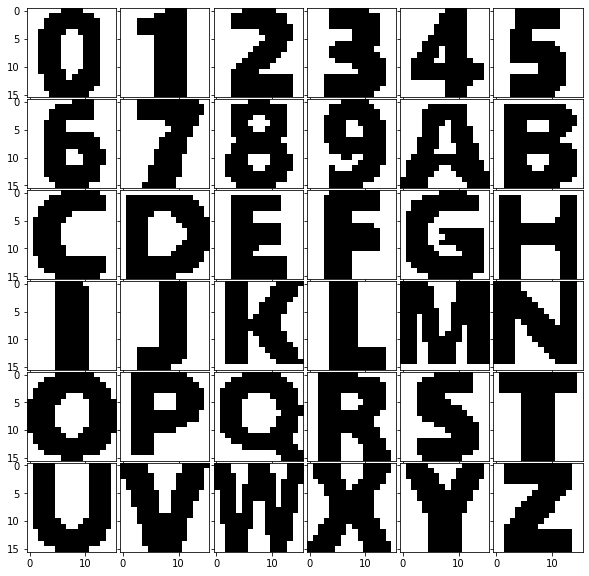

In [322]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(data[i].reshape(16, 16), 'gray')    

In [323]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))

## 2. Model Designing and Training

In [324]:
from random import randint
# metrics for measuring the performance of the model
ffa = []
fh = []


model = DeepNet(layerSize=[256]+[256]*3+[256])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
for epochs in range(0, 1100, 100):
    
    #Train the model with MSE loss criterion and Adam optimizer function
    train(data, data, model, criterion, optimizer, 100)
    
    # Compute errors and predicted output 
    pred, err = test(data=data, target=data, model=model)
    fh += [np.mean(err[0])]
    ffa += [np.mean(err[1])]

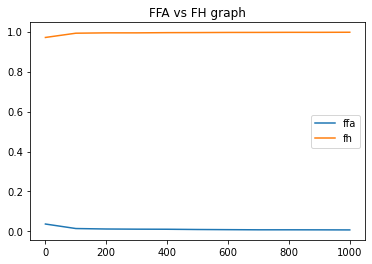

In [325]:
plt.plot(range(0, 1100, 100), ffa, label='ffa')
plt.plot(range(0, 1100, 100), fh, label='fh')

plt.title("FFA vs FH graph")
plt.legend()

### At 250 epochs we achieve FH and FFA scores of around 1 and 0 respectively, which is why we have chosed to run the experiments with 250 epochs

In [326]:
model = DeepNet(layerSize=[256]+[256]*3+[256])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(data, data, model, criterion, optimizer, 250);

## 3. Testing the model

### Displaying the predicted images for running the model on dataset #1

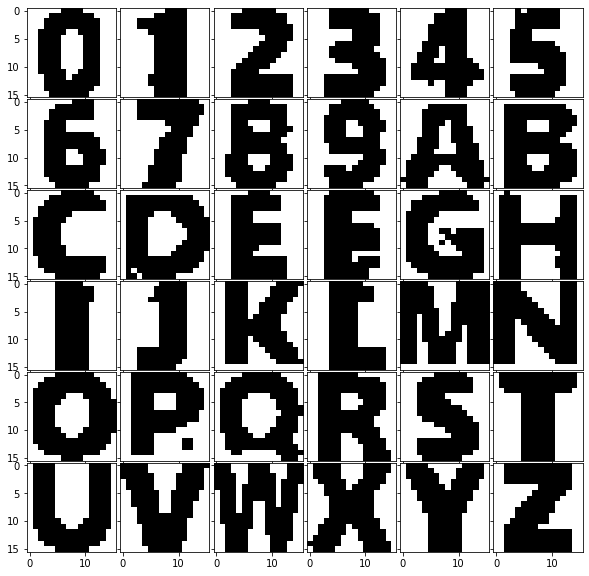

In [327]:
ffa = []
fh = []
pred, err = test(data=data, target=data, model=model)
fig = plt.figure(figsize=(10, 10))
fh += err[0]
ffa += err[1]
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    

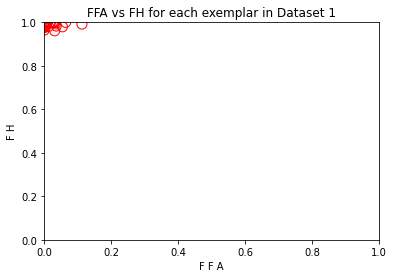

In [328]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

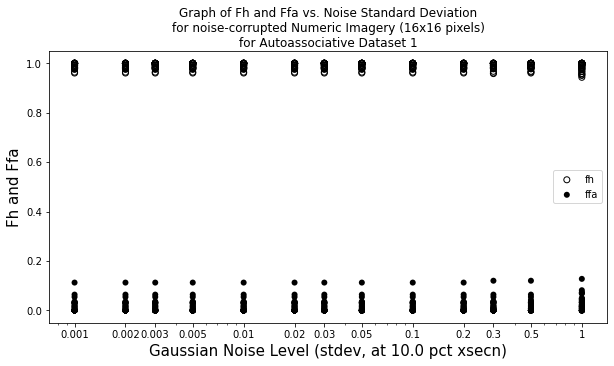

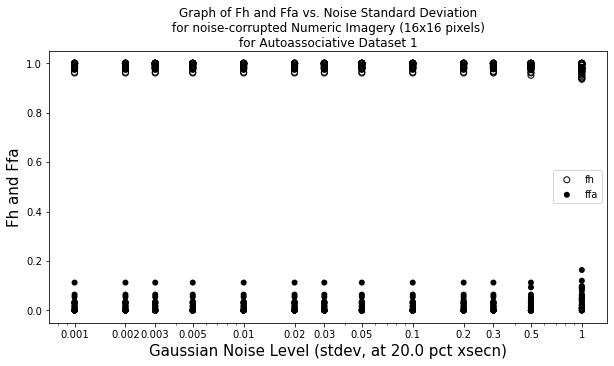

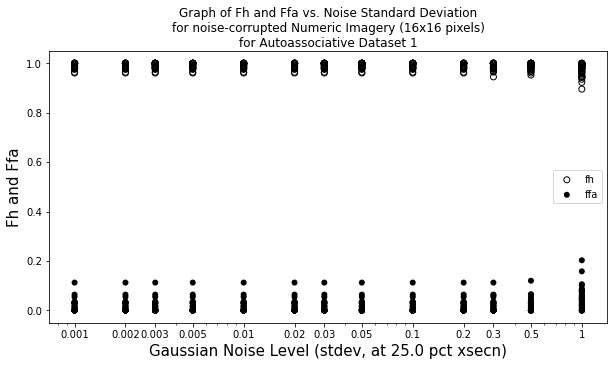

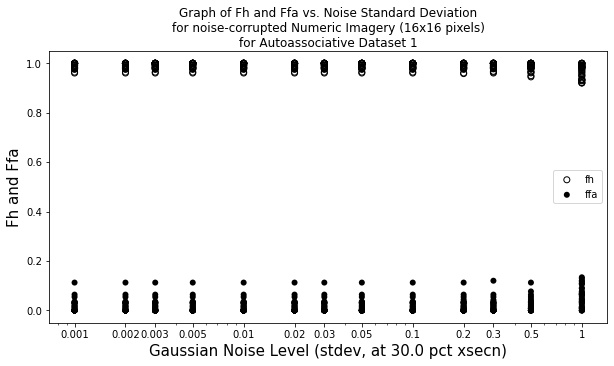

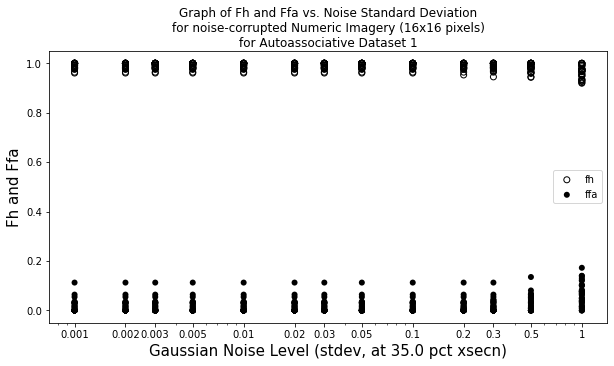

In [329]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in data:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(data)
        predicted_values = generate_predictions(noisy_data, model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Autoassociative Dataset 1"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [330]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.054264,0.062016
1,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.032680,0.130719
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.076923
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.047619
4,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.172662
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.015152,0.068182,0.083333
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.030303,0.068182
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.027397,0.123288
8,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.042373,0.050847,0.050847


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.054264,0.062016
1,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.032680,0.130719
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.076923
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.047619
4,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.172662
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.015152,0.068182,0.083333
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.030303,0.068182
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.027397,0.123288
8,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.042373,0.050847,0.050847


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.054264,0.062016
1,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.032680,0.130719
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.076923
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.047619
4,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.172662
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.015152,0.068182,0.083333
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.030303,0.068182
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.027397,0.123288
8,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.042373,0.050847,0.050847


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.054264,0.062016
1,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.032680,0.130719
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.076923
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.047619
4,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.172662
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.015152,0.068182,0.083333
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.030303,0.068182
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.027397,0.123288
8,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.042373,0.050847,0.050847


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.054264,0.062016
1,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.013072,0.032680,0.130719
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.076923
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.047619
4,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.035971,0.172662
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.015152,0.068182,0.083333
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007576,0.030303,0.068182
7,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.027397,0.123288
8,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.033898,0.042373,0.050847,0.050847


In [331]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976378
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.932039
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992063
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976923,0.969231
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.957265
5,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.967742,0.943548,0.935484
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.967742
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972727
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.985507,0.992754,0.992754


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976378
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.932039
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992063
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976923,0.969231
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.957265
5,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.967742,0.943548,0.935484
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.967742
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972727
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.985507,0.992754,0.992754


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976378
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.932039
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992063
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976923,0.969231
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.957265
5,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.967742,0.943548,0.935484
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.967742
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972727
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.985507,0.992754,0.992754


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976378
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.932039
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992063
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976923,0.969231
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.957265
5,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.967742,0.943548,0.935484
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.967742
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972727
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.985507,0.992754,0.992754


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976378
1,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.980583,0.932039
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992063
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976923,0.969231
4,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.982906,0.957265
5,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.975806,0.967742,0.943548,0.935484
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991935,0.967742
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972727
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.985507,0.992754,0.992754


### reading the dataset #2

In [332]:
#read images
serif=[]
chars = [i for i in range(48, 48+10)] + [i for i in range(65, 65+26)]
for i in chars:
    img = cv2.imread('dataset/serif/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    serif.append(np.array(final_img, dtype=np.float32).flatten())


### Testing the model against dataset #2

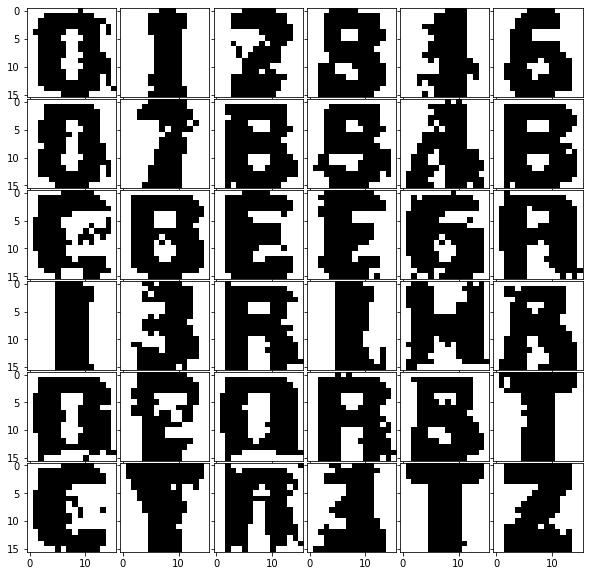

In [333]:
fh_e, ffa_e = [], []
pred, err = test(data=serif, target=data, model=model)

fh_e += err[0]
ffa_e += err[1]

fh = [np.median(err[0]), np.mean(err[0]), np.std(err[0])]
ffa = [np.median(err[1]), np.mean(err[1]), np.std(err[1])]
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 6, hspace=0.02, wspace=0.02)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(36):
    axs[i//6, i%6].imshow(pred[i], 'gray')    


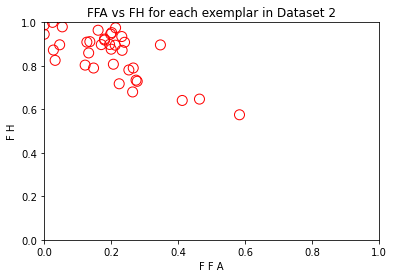

In [334]:
plt.scatter(ffa_e, fh_e, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 2")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

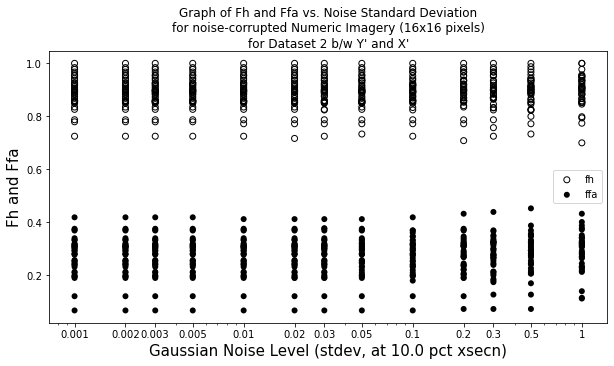

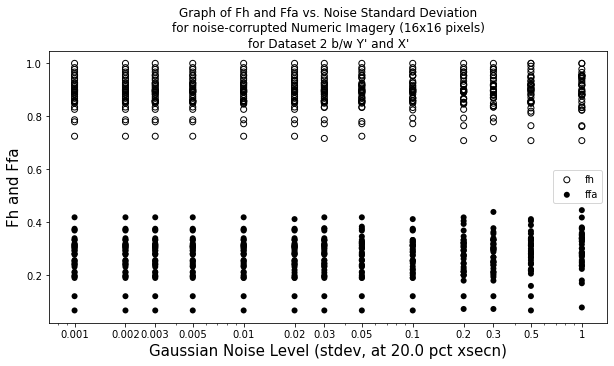

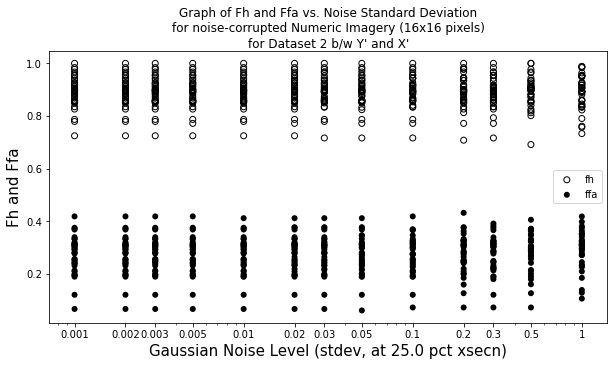

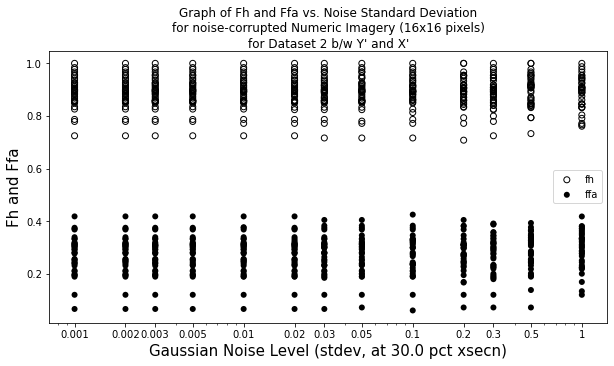

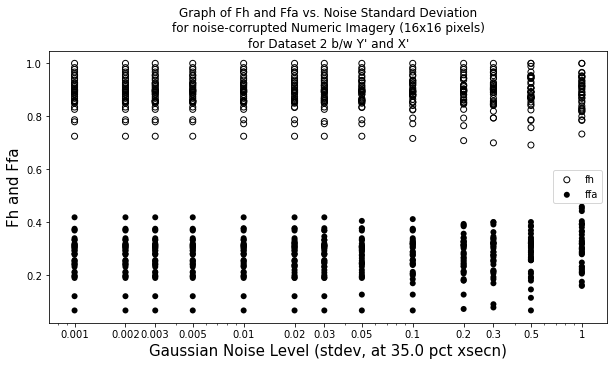

In [335]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in serif:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(serif)
        predicted_values = generate_predictions(noisy_data, model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Dataset 2 b/w Y' and X'"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

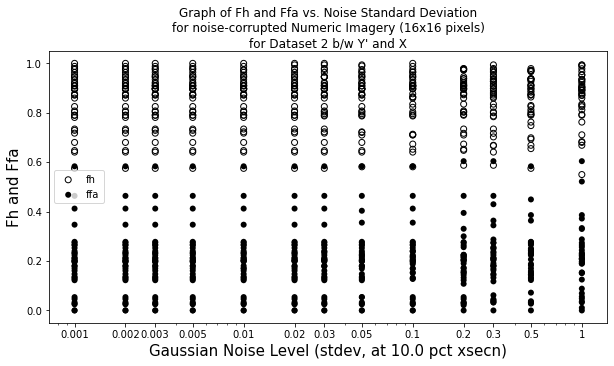

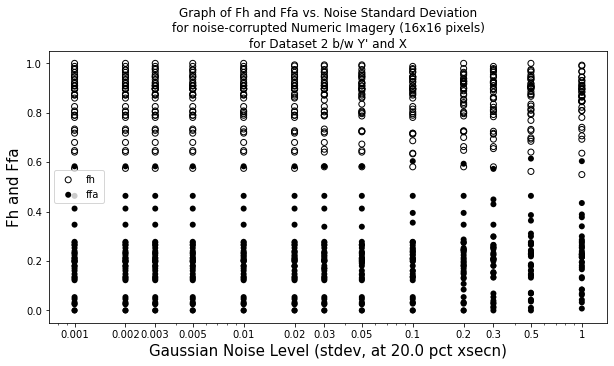

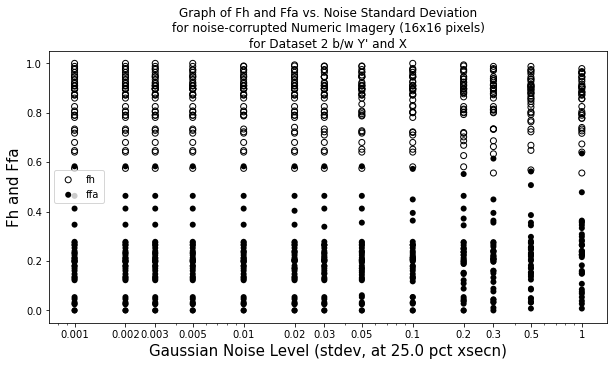

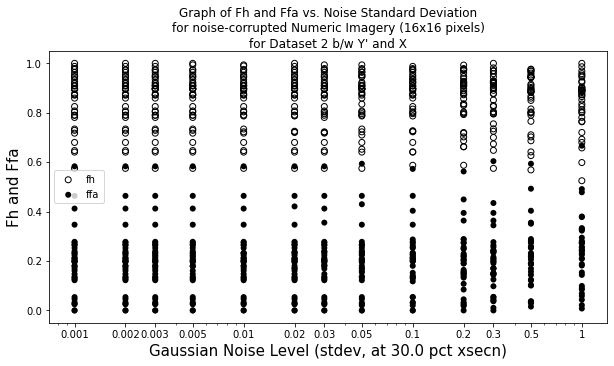

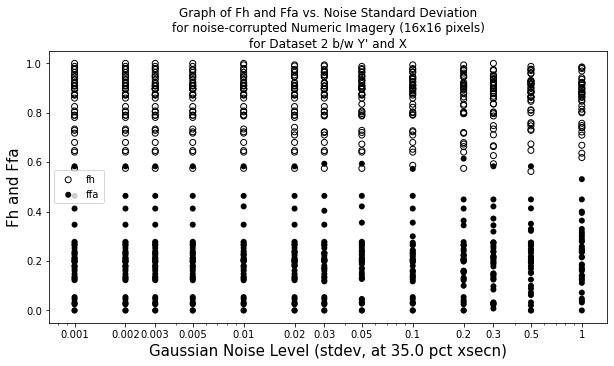

In [336]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in serif:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(data)
        predicted_values = generate_predictions(noisy_data, model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for Dataset 2 b/w Y\' and X"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.yticks([i*0.1 for i in range(0, 11, 2)])
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [337]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.209302,0.217054,0.209302,0.217054,0.248062,0.279070
1,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.039216
2,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.100000,0.084615,0.100000,0.123077
3,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.206349,0.182540
4,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.129496,0.136691,0.122302,0.136691,0.194245,0.258993
5,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.143939,0.143939,0.159091,0.143939,0.151515,0.166667
6,0.212121,0.212121,0.212121,0.212121,0.204545,0.204545,0.204545,0.227273,0.204545,0.219697,0.212121,0.204545,0.280303
7,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.041096,0.027397,0.020548,0.047945
8,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.169492,0.161017,0.161017,0.177966,0.169492,0.127119


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.209302,0.217054,0.209302,0.217054,0.248062,0.279070
1,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.039216
2,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.100000,0.084615,0.100000,0.123077
3,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.206349,0.182540
4,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.129496,0.136691,0.122302,0.136691,0.194245,0.258993
5,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.143939,0.143939,0.159091,0.143939,0.151515,0.166667
6,0.212121,0.212121,0.212121,0.212121,0.204545,0.204545,0.204545,0.227273,0.204545,0.219697,0.212121,0.204545,0.280303
7,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.041096,0.027397,0.020548,0.047945
8,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.169492,0.161017,0.161017,0.177966,0.169492,0.127119


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.209302,0.217054,0.209302,0.217054,0.248062,0.279070
1,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.039216
2,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.100000,0.084615,0.100000,0.123077
3,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.206349,0.182540
4,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.129496,0.136691,0.122302,0.136691,0.194245,0.258993
5,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.143939,0.143939,0.159091,0.143939,0.151515,0.166667
6,0.212121,0.212121,0.212121,0.212121,0.204545,0.204545,0.204545,0.227273,0.204545,0.219697,0.212121,0.204545,0.280303
7,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.041096,0.027397,0.020548,0.047945
8,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.169492,0.161017,0.161017,0.177966,0.169492,0.127119


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.209302,0.217054,0.209302,0.217054,0.248062,0.279070
1,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.039216
2,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.100000,0.084615,0.100000,0.123077
3,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.206349,0.182540
4,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.129496,0.136691,0.122302,0.136691,0.194245,0.258993
5,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.143939,0.143939,0.159091,0.143939,0.151515,0.166667
6,0.212121,0.212121,0.212121,0.212121,0.204545,0.204545,0.204545,0.227273,0.204545,0.219697,0.212121,0.204545,0.280303
7,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.041096,0.027397,0.020548,0.047945
8,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.169492,0.161017,0.161017,0.177966,0.169492,0.127119


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.201550,0.209302,0.217054,0.209302,0.217054,0.248062,0.279070
1,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.039216
2,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.046154,0.100000,0.084615,0.100000,0.123077
3,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.198413,0.206349,0.182540
4,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.122302,0.129496,0.136691,0.122302,0.136691,0.194245,0.258993
5,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.136364,0.143939,0.143939,0.159091,0.143939,0.151515,0.166667
6,0.212121,0.212121,0.212121,0.212121,0.204545,0.204545,0.204545,0.227273,0.204545,0.219697,0.212121,0.204545,0.280303
7,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.027397,0.041096,0.027397,0.020548,0.047945
8,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.161017,0.169492,0.161017,0.161017,0.177966,0.169492,0.127119


In [338]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.944882,0.960630,0.921260,0.960630,0.913386
1,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.834951,0.834951,0.834951,0.834951,0.864078,0.941748
2,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.904762,0.912698,0.904762,0.888889,0.865079,0.920635
3,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.938462,0.946154,0.938462,0.915385,0.923077
4,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.811966,0.709402
5,0.911290,0.911290,0.911290,0.911290,0.911290,0.911290,0.919355,0.927419,0.911290,0.919355,0.919355,0.927419,0.935484
6,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.911290,0.911290,0.927419,0.911290
7,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.881818,0.854545,0.881818,0.881818,0.872727
8,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.971014,0.971014,0.971014,0.985507


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.944882,0.960630,0.921260,0.960630,0.913386
1,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.834951,0.834951,0.834951,0.834951,0.864078,0.941748
2,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.904762,0.912698,0.904762,0.888889,0.865079,0.920635
3,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.938462,0.946154,0.938462,0.915385,0.923077
4,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.811966,0.709402
5,0.911290,0.911290,0.911290,0.911290,0.911290,0.911290,0.919355,0.927419,0.911290,0.919355,0.919355,0.927419,0.935484
6,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.911290,0.911290,0.927419,0.911290
7,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.881818,0.854545,0.881818,0.881818,0.872727
8,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.971014,0.971014,0.971014,0.985507


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.944882,0.960630,0.921260,0.960630,0.913386
1,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.834951,0.834951,0.834951,0.834951,0.864078,0.941748
2,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.904762,0.912698,0.904762,0.888889,0.865079,0.920635
3,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.938462,0.946154,0.938462,0.915385,0.923077
4,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.811966,0.709402
5,0.911290,0.911290,0.911290,0.911290,0.911290,0.911290,0.919355,0.927419,0.911290,0.919355,0.919355,0.927419,0.935484
6,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.911290,0.911290,0.927419,0.911290
7,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.881818,0.854545,0.881818,0.881818,0.872727
8,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.971014,0.971014,0.971014,0.985507


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.944882,0.960630,0.921260,0.960630,0.913386
1,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.834951,0.834951,0.834951,0.834951,0.864078,0.941748
2,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.904762,0.912698,0.904762,0.888889,0.865079,0.920635
3,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.938462,0.946154,0.938462,0.915385,0.923077
4,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.811966,0.709402
5,0.911290,0.911290,0.911290,0.911290,0.911290,0.911290,0.919355,0.927419,0.911290,0.919355,0.919355,0.927419,0.935484
6,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.911290,0.911290,0.927419,0.911290
7,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.881818,0.854545,0.881818,0.881818,0.872727
8,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.971014,0.971014,0.971014,0.985507


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.952756,0.944882,0.960630,0.921260,0.960630,0.913386
1,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.834951,0.834951,0.834951,0.834951,0.864078,0.941748
2,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.896825,0.904762,0.912698,0.904762,0.888889,0.865079,0.920635
3,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.946154,0.938462,0.946154,0.938462,0.915385,0.923077
4,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.803419,0.811966,0.709402
5,0.911290,0.911290,0.911290,0.911290,0.911290,0.911290,0.919355,0.927419,0.911290,0.919355,0.919355,0.927419,0.935484
6,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.895161,0.911290,0.911290,0.927419,0.911290
7,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.872727,0.881818,0.854545,0.881818,0.881818,0.872727
8,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.963768,0.971014,0.971014,0.971014,0.985507


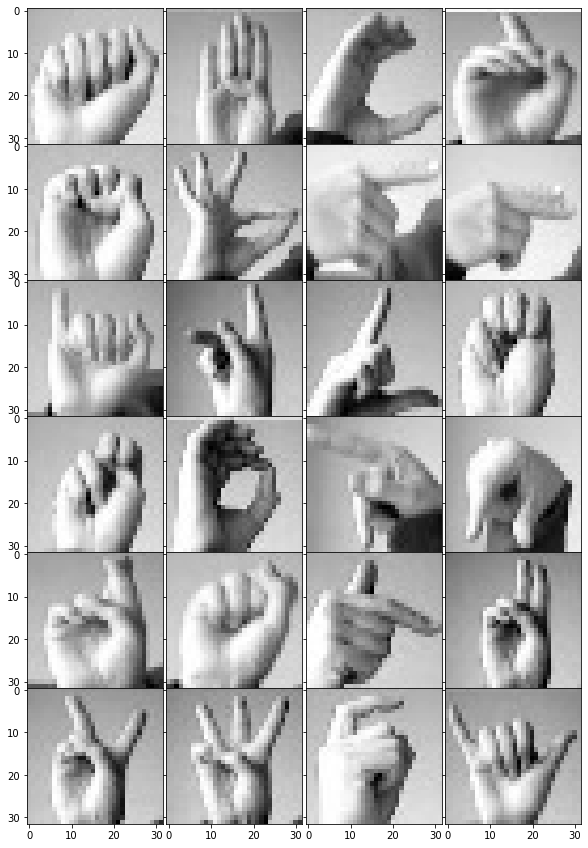

In [339]:
asl = []
asl_targets = []
ach = [i for i in range(65, 65+25)]
ach.remove(ord('J'))
for i in ach:
    img = cv2.imread('dataset/asl/32px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im = np.array(img_gray, dtype=np.float32).flatten()
    im = im/255
    asl.append(im)
    img = cv2.imread('dataset/sans/16px/%s.jpg' %chr(i))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    asl_targets.append(np.array(final_img, dtype=np.float32).flatten())
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(asl[i].reshape(32, 32), 'gray')

In [340]:
ffa = []
fh = []
asl_model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(asl_model.parameters(), lr = 0.001)
for epochs in range(100, 1100, 100):
    train(asl, asl_targets, asl_model, criterion, optimizer, 100)
    pred, err = test(data=asl, target=asl_targets, model=asl_model)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


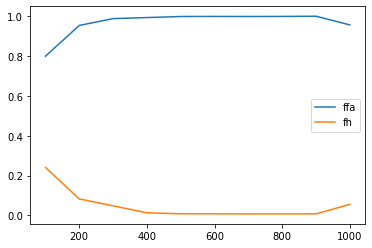

In [341]:
plt.figure()
plt.plot(range(100, 1100, 100), ffa, label='ffa')
plt.plot(range(100, 1100, 100), fh, label='fh')
plt.legend()    

In [342]:
model = DeepNet(layerSize=[1024]+[1024, 512, 256]+[256])
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(asl, asl_targets, asl_model, criterion, optimizer, 450);

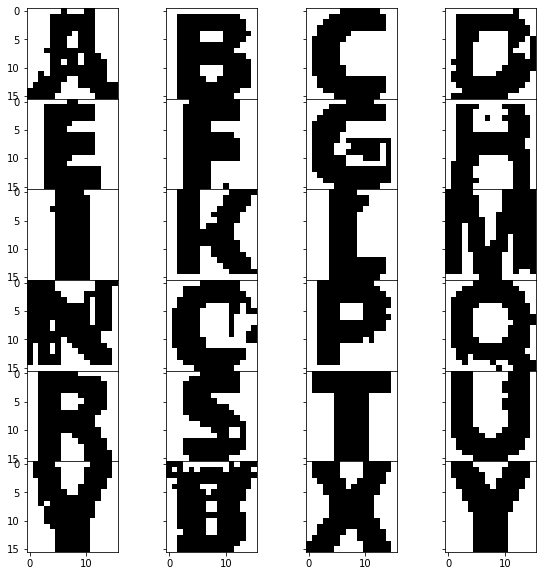

In [343]:
pred, err = test(data=asl, target=asl_targets, model=asl_model)
fh = [err[0]]
ffa = [err[1]]
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(24):
    axs[i//4, i%4].imshow(pred[i], 'gray')    

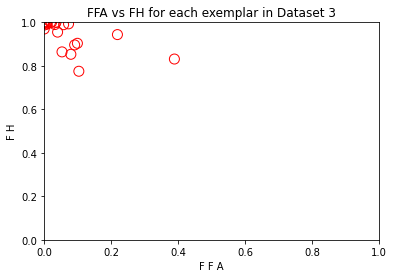

In [344]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 3")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

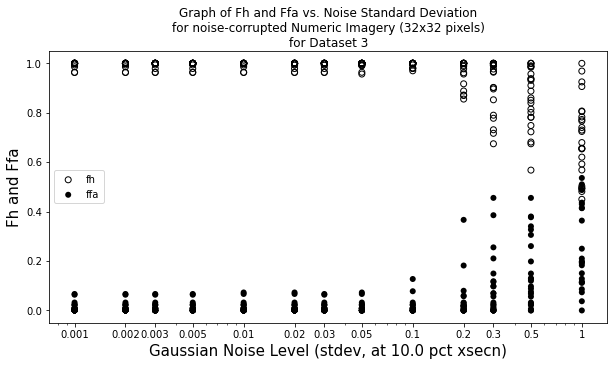

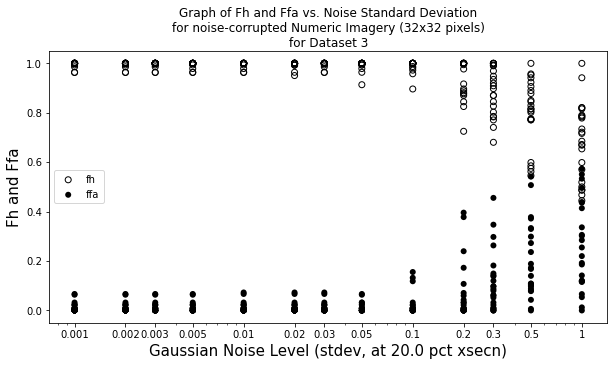

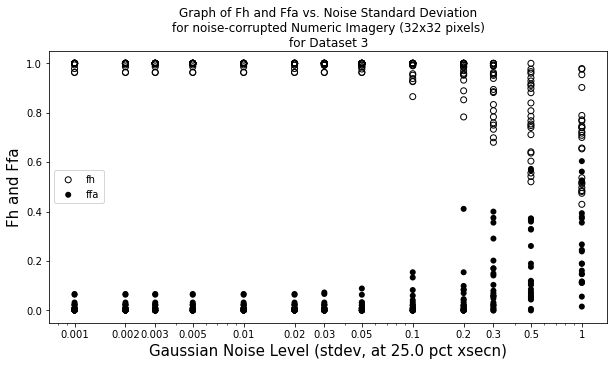

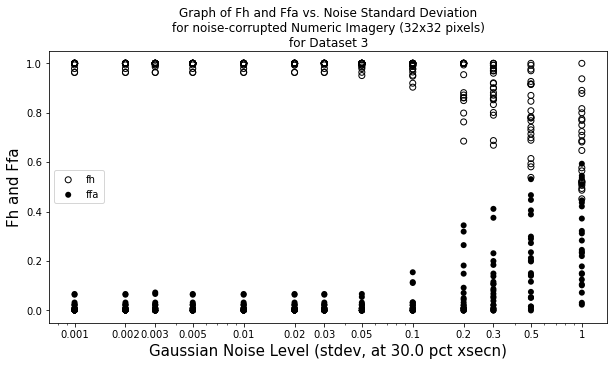

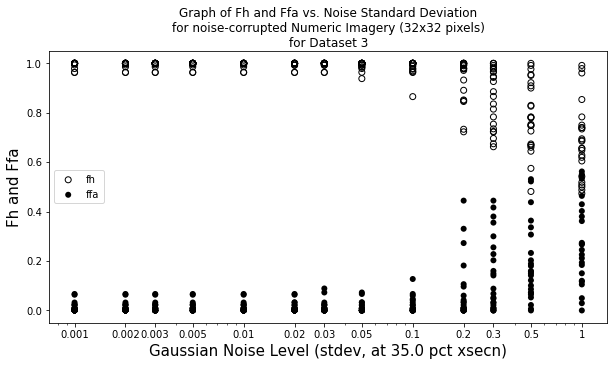

In [345]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in asl:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(asl_targets)
        predicted_values = generate_predictions(noisy_data, asl_model)
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*24 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (32x32 pixels)\n"
        "for Dataset 3"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [346]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330579,0.380165,0.363636,0.380165
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.010753,0.064516,0.225806
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100775,0.193798
3,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106383,0.255319,0.159574,0.361702
4,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.029412
5,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.067669,0.052632,0.105263
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.060000,0.060000,0.160000,0.180000,0.270000
7,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.041322,0.272727,0.355372,0.438017,0.545455
8,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.049689


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330579,0.380165,0.363636,0.380165
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.010753,0.064516,0.225806
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100775,0.193798
3,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106383,0.255319,0.159574,0.361702
4,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.029412
5,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.067669,0.052632,0.105263
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.060000,0.060000,0.160000,0.180000,0.270000
7,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.041322,0.272727,0.355372,0.438017,0.545455
8,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.049689


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330579,0.380165,0.363636,0.380165
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.010753,0.064516,0.225806
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100775,0.193798
3,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106383,0.255319,0.159574,0.361702
4,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.029412
5,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.067669,0.052632,0.105263
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.060000,0.060000,0.160000,0.180000,0.270000
7,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.041322,0.272727,0.355372,0.438017,0.545455
8,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.049689


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330579,0.380165,0.363636,0.380165
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.010753,0.064516,0.225806
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100775,0.193798
3,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106383,0.255319,0.159574,0.361702
4,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.029412
5,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.067669,0.052632,0.105263
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.060000,0.060000,0.160000,0.180000,0.270000
7,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.041322,0.272727,0.355372,0.438017,0.545455
8,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.049689


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330579,0.380165,0.363636,0.380165
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010753,0.010753,0.064516,0.225806
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100775,0.193798
3,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106383,0.255319,0.159574,0.361702
4,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.022059,0.029412
5,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.007519,0.067669,0.052632,0.105263
6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.060000,0.060000,0.160000,0.180000,0.270000
7,0.024793,0.024793,0.024793,0.024793,0.024793,0.033058,0.024793,0.033058,0.041322,0.272727,0.355372,0.438017,0.545455
8,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.006211,0.049689


In [347]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985185,0.992593,0.733333,0.696296,0.481481,0.518519
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.932515,0.926380,0.748466,0.619632
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984252,0.779528,0.685039
3,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.938272,0.987654,0.845679,0.722222,0.753086,0.604938
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.991667,0.991667
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943089,0.951220,0.853659
6,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.865385,0.891026,0.724359,0.660256,0.628205
7,1.000000,1.000000,1.000000,1.000000,1.000000,0.992593,0.992593,0.985185,0.962963,0.851852,0.814815,0.644444,0.688889
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978947


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985185,0.992593,0.733333,0.696296,0.481481,0.518519
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.932515,0.926380,0.748466,0.619632
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984252,0.779528,0.685039
3,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.938272,0.987654,0.845679,0.722222,0.753086,0.604938
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.991667,0.991667
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943089,0.951220,0.853659
6,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.865385,0.891026,0.724359,0.660256,0.628205
7,1.000000,1.000000,1.000000,1.000000,1.000000,0.992593,0.992593,0.985185,0.962963,0.851852,0.814815,0.644444,0.688889
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978947


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985185,0.992593,0.733333,0.696296,0.481481,0.518519
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.932515,0.926380,0.748466,0.619632
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984252,0.779528,0.685039
3,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.938272,0.987654,0.845679,0.722222,0.753086,0.604938
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.991667,0.991667
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943089,0.951220,0.853659
6,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.865385,0.891026,0.724359,0.660256,0.628205
7,1.000000,1.000000,1.000000,1.000000,1.000000,0.992593,0.992593,0.985185,0.962963,0.851852,0.814815,0.644444,0.688889
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978947


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985185,0.992593,0.733333,0.696296,0.481481,0.518519
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.932515,0.926380,0.748466,0.619632
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984252,0.779528,0.685039
3,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.938272,0.987654,0.845679,0.722222,0.753086,0.604938
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.991667,0.991667
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943089,0.951220,0.853659
6,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.865385,0.891026,0.724359,0.660256,0.628205
7,1.000000,1.000000,1.000000,1.000000,1.000000,0.992593,0.992593,0.985185,0.962963,0.851852,0.814815,0.644444,0.688889
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978947


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985185,0.992593,0.733333,0.696296,0.481481,0.518519
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.932515,0.926380,0.748466,0.619632
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984252,0.779528,0.685039
3,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.962963,0.938272,0.987654,0.845679,0.722222,0.753086,0.604938
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.991667,0.991667
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943089,0.951220,0.853659
6,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.993590,0.865385,0.891026,0.724359,0.660256,0.628205
7,1.000000,1.000000,1.000000,1.000000,1.000000,0.992593,0.992593,0.985185,0.962963,0.851852,0.814815,0.644444,0.688889
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978947


In [348]:
from sem import sem_data
model1 = DeepNet(layerSize=[256]+[150, 150, 150]+[81])
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)
model2 = DeepNet(layerSize=[81]+[150, 150, 150]+[256])
criterion2 = torch.nn.MSELoss(size_average = False)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)
sem_data = np.array(sem_data)
ffa = []
fh = []
loss = []
for epochs in range(100, 1100, 100):
    loss += train(data, sem_data, model1, criterion1, optimizer1, 100)
    features = test_class(data=data, target=sem_data, model=model1)
for epochs in range(100, 1100, 100):
    train(features, data, model2, criterion2, optimizer2, 100)
    pred, err = test(data=features, target=data, model=model2)
    ffa += [np.mean(err[0])]
    fh += [np.mean(err[1])]

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


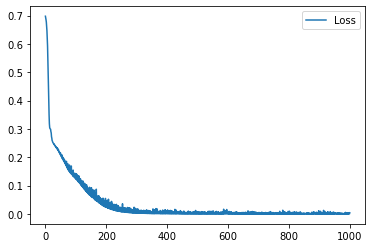

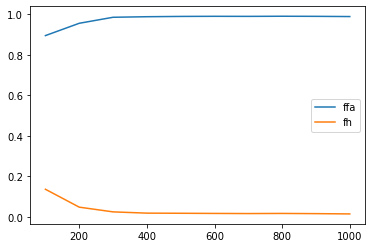

In [349]:
plt.figure()
plt.plot(range(1000), loss, label='Loss')
plt.legend()    
plt.figure()
plt.plot(range(100, 1100, 100), ffa, label='ffa')
plt.plot(range(100, 1100, 100), fh, label='fh')
plt.legend()    

In [350]:
model1 = DeepNet(layerSize=[256]+[256, 150, 81]+[81])
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)
model2 = DeepNet(layerSize=[81]+[81, 100, 128]+[256])
criterion2 = torch.nn.MSELoss(size_average = False)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)
sem_data = np.array(sem_data)
ffa = []
fh = []
loss = []
train(data, sem_data, model1, criterion1, optimizer1, 450)
features = test_class(data=data, target=sem_data, model=model1)
train(features, data, model2, criterion2, optimizer2, 450)
pred, err = test(data=features, target=data, model=model2)
ffa += [np.mean(err[0])]
fh += [np.mean(err[1])]

In [351]:
features = test_class(data=serif, target=sem_data, model=model1)
pred, err = test(data=features, target=data, model=model2)
ffa = [err[1]]
fh = [err[0]]

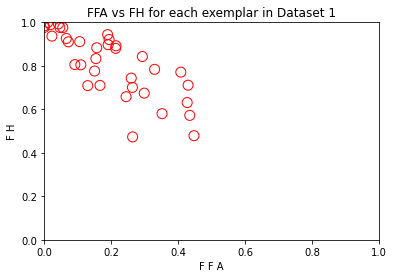

In [352]:
plt.scatter(ffa, fh, s=100, facecolors='none', edgecolors='r')
plt.title("FFA vs FH for each exemplar in Dataset 1")
plt.xlabel('F F A') 
plt.ylabel('F H') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

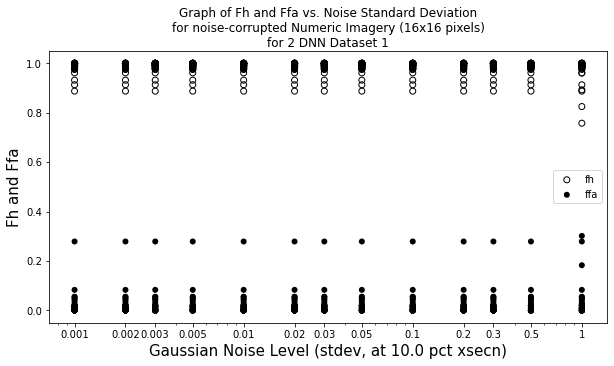

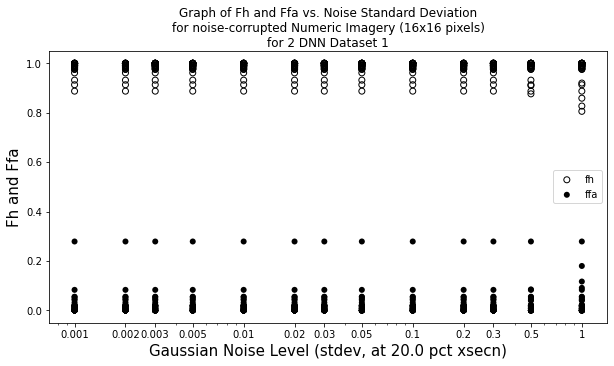

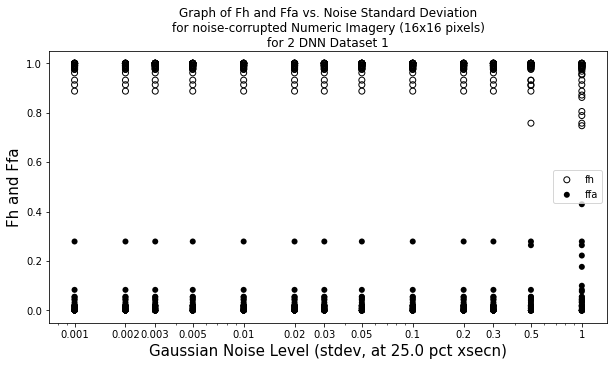

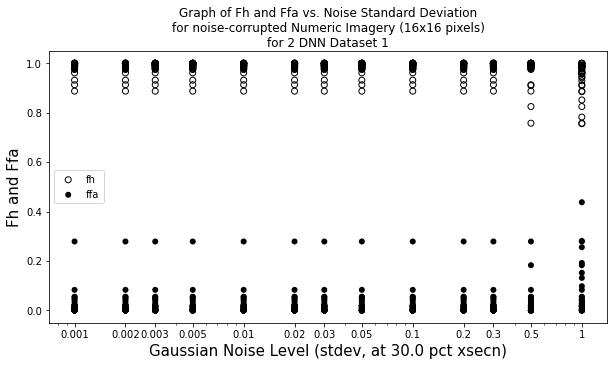

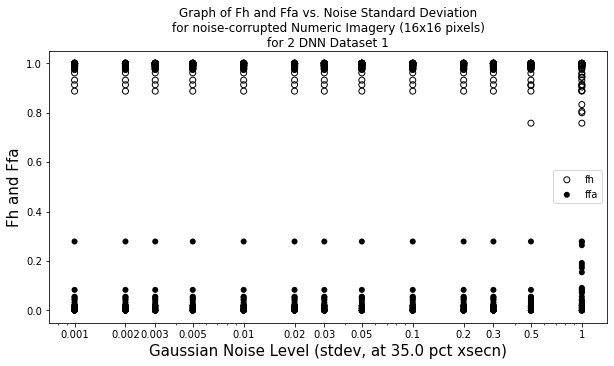

In [353]:
dfa = [pd.DataFrame()]*5
dfh = [pd.DataFrame()]*5
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
cxs = [0.1, 0.2, 0.25, 0.3, 0.35]
for i, cx in enumerate(cxs):
    ffa, fh = [], []
    dfa[i].index.name = 'Image ID'
    dfh[i].index.name = 'Image ID'
    for s in range(13):
        noisy_data = []
        for d in data:
            nd = add_noise(np.copy(d), cx, sigma[s])
            noisy_data.append(normalize(nd))
        target_values = generate_rescaled_inputs(data)
        features = test_class(data=noisy_data, target=sem_data, model=model1)
        pred, err = test(data=features, target=data, model=model2)
        predicted_values = pred
        # for i in range(10):
        #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
        h, a = compute_error_metrics(target_values, predicted_values)
        ffa += a
        fh += h
        dfa[i]['%s' %sigma[s]] = a
        dfh[i]['%s' %sigma[s]] = h
    x = [[s]*36 for s in sigma]
    plt.figure(figsize=(10, 5))
    plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
        "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
        "for 2 DNN Dataset 1"), loc='center', wrap=True)
    plt.xlabel(f'Gaussian Noise Level (stdev, at {cx*100} pct xsecn)', size=15)
    plt.ylabel('Fh and Ffa', size=15)
    plt.xscale('log')
    plt.xticks(sigma, sigma)
    plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
    plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
    plt.legend()

In [354]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'ffa values at stdev for {cx*100} xsecn')
    display(dfa[i])

ffa values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.091503
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.192308
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.022727
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548
8,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373


ffa values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.091503
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.192308
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.022727
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548
8,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373


ffa values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.091503
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.192308
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.022727
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548
8,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373


ffa values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.091503
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.192308
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.022727
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548
8,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373


ffa values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070,0.279070
1,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.091503
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.192308
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.022727
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548,0.020548
8,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373,0.042373


In [355]:
from IPython.display import display
for i, cx in enumerate(cxs):
    print(f'fh values at stdev for {cx*100} xsecn')
    display(dfh[i])

fh values at stdev for 10.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386
1,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.805825
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960317
3,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.800000
4,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.959677,0.943548
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 20.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386
1,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.805825
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960317
3,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.800000
4,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.959677,0.943548
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 25.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386
1,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.805825
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960317
3,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.800000
4,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.959677,0.943548
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 30.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386
1,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.805825
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960317
3,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.800000
4,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.959677,0.943548
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754


fh values at stdev for 35.0 xsecn


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386,0.913386
1,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.932039,0.805825
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960317
3,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.992308,0.800000
4,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453,0.991453
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.959677,0.943548
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754,0.992754
